In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Works\waze_dataset.csv")


print(df.info())  
print(df.head())  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB
None
   ID     labe

In [2]:
import os
os.makedirs("waze_visuals", exist_ok=True)


In [3]:
df = df.dropna(subset=['label'])

df['label'].fillna(df['label'].mode()[0], inplace=True)

print(df.isnull().sum())  


ID                         0
label                      0
sessions                   0
drives                     0
total_sessions             0
n_days_after_onboarding    0
total_navigations_fav1     0
total_navigations_fav2     0
driven_km_drives           0
duration_minutes_drives    0
activity_days              0
driving_days               0
device                     0
dtype: int64


C:\Users\gowth\AppData\Local\Temp\ipykernel_16948\3785964032.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].fillna(df['label'].mode()[0], inplace=True)


In [4]:
df = pd.get_dummies(df, columns=['device'], drop_first=True)

print(df.head())


   ID     label  sessions  drives  total_sessions  n_days_after_onboarding  \
0   0  retained       283     226      296.748273                     2276   
1   1  retained       133     107      326.896596                     1225   
2   2  retained       114      95      135.522926                     2651   
3   3  retained        49      40       67.589221                       15   
4   4  retained        84      68      168.247020                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   
3                     322                       7        913.591123   
4                     166                       5       3950.202008   

   duration_minutes_drives  activity_days  driving_days  device_iPhone  
0              1985.775061     

In [5]:
from sklearn.preprocessing import StandardScaler

scale_cols = ['driven_km_drives', 'duration_minutes_drives', 'total_sessions']

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

print(df.head())  


   ID     label  sessions  drives  total_sessions  n_days_after_onboarding  \
0   0  retained       283     226        0.787171                     2276   
1   1  retained       133     107        1.008549                     1225   
2   2  retained       114      95       -0.396699                     2651   
3   3  retained        49      40       -0.895533                       15   
4   4  retained        84      68       -0.156408                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0         -0.565117   
1                      19                      64          3.861055   
2                       0                       0         -0.393332   
3                     322                       7         -1.249879   
4                     166                       5         -0.037606   

   duration_minutes_drives  activity_days  driving_days  device_iPhone  
0                 0.083963     

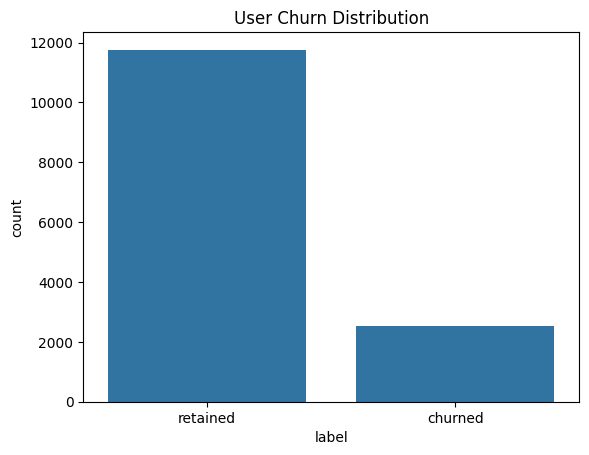

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df)
plt.title("User Churn Distribution")
plt.savefig("waze_visuals/image1", dpi=300)
plt.show()


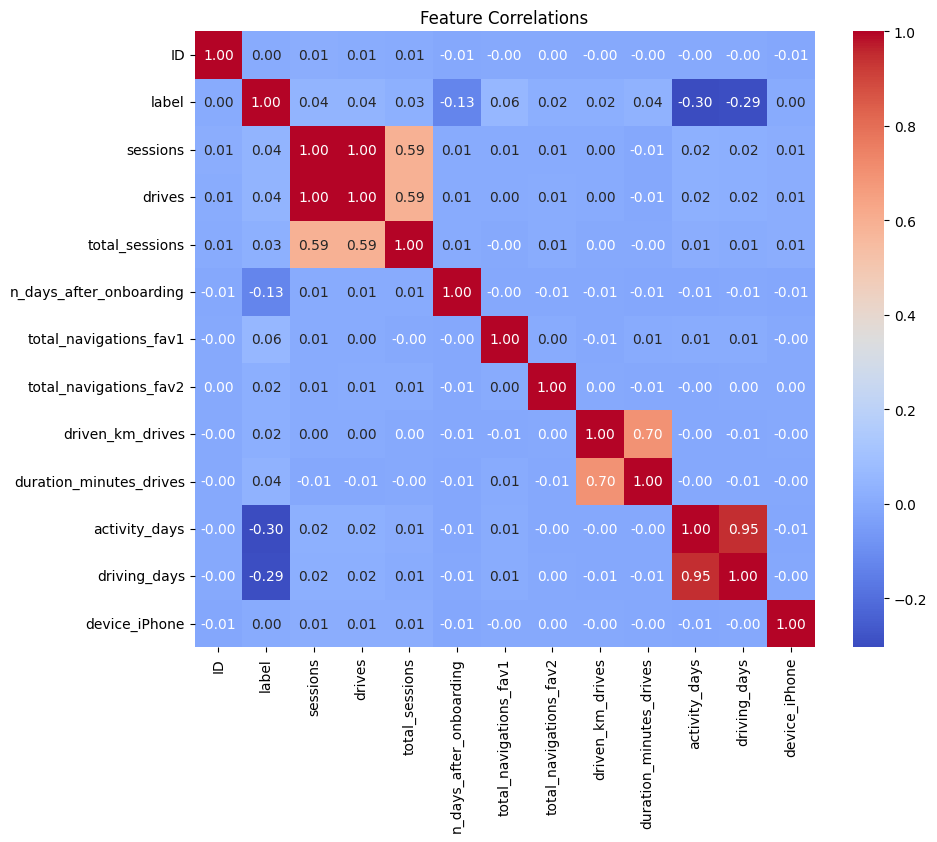

In [7]:
df['label'] = df['label'].map({'churned': 1, 'retained': 0})

corr = df.corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.savefig("waze_visuals/image2", dpi=300)

plt.show()


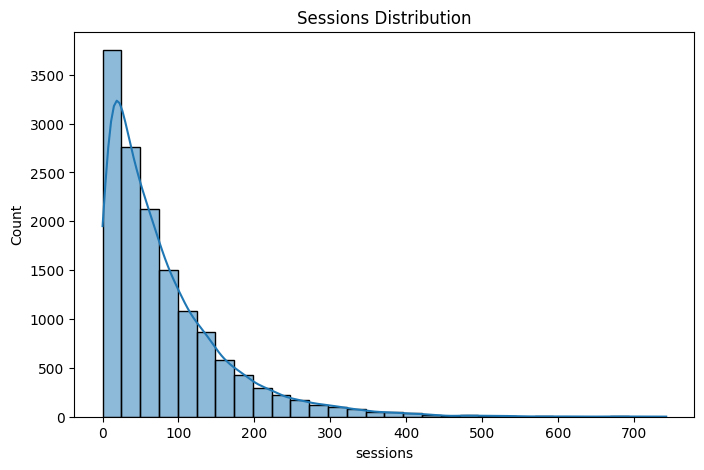

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df['sessions'], bins=30, kde=True)
plt.title("Sessions Distribution")
plt.savefig("waze_visuals/image3", dpi=300)

plt.show()


In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['label', 'ID'])  # Drop label & ID
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train Size:", X_train.shape, "Test Size:", X_test.shape)


Train Size: (11439, 11) Test Size: (2860, 11)


In [10]:
!pip install xgboost


In [11]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.8174825174825174
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2353
           1       0.45      0.13      0.20       507

    accuracy                           0.82      2860
   macro avg       0.64      0.55      0.55      2860
weighted avg       0.77      0.82      0.77      2860



In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8241258741258741
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2353
           1       0.70      0.01      0.03       507

    accuracy                           0.82      2860
   macro avg       0.76      0.51      0.47      2860
weighted avg       0.80      0.82      0.75      2860



In [14]:
pip install scikit-learn==1.3.2


Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install imbalanced-learn==0.11.0


Note: you may need to restart the kernel to use updated packages.


In [16]:
import sklearn
import imblearn

print("scikit-learn version:", sklearn.__version__)
print("imblearn version:", imblearn.__version__)


scikit-learn version: 1.3.2
imblearn version: 0.11.0


In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:", X_train_sm.shape, y_train_sm.value_counts())


After SMOTE: (18820, 11) label
0    9410
1    9410
Name: count, dtype: int64


In [18]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

xgb = XGBClassifier(random_state=42)
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_sm, y_train_sm)

print("Best XGBoost Parameters:", grid_xgb.best_params_)


Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}


In [19]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}


rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_sm, y_train_sm)


print("Best Random Forest Parameters:", grid_rf.best_params_)


Best Random Forest Parameters: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 200}


In [20]:
xgb_best = XGBClassifier(**grid_xgb.best_params_, random_state=42)
xgb_best.fit(X_train_sm, y_train_sm)

y_pred_xgb_best = xgb_best.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_best))
print(classification_report(y_test, y_pred_xgb_best))


XGBoost Accuracy: 0.7314685314685314
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      2353
           1       0.31      0.40      0.35       507

    accuracy                           0.73      2860
   macro avg       0.58      0.60      0.59      2860
weighted avg       0.76      0.73      0.75      2860



In [21]:
rf_best = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
rf_best.fit(X_train_sm, y_train_sm)

y_pred_rf_best = rf_best.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf_best))
print(classification_report(y_test, y_pred_rf_best))


Random Forest Accuracy: 0.6821678321678322
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      2353
           1       0.30      0.61      0.41       507

    accuracy                           0.68      2860
   macro avg       0.60      0.66      0.59      2860
weighted avg       0.79      0.68      0.72      2860



In [22]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb, cv=3, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train_sm, y_train_sm)

print("Best XGBoost Parameters:", grid_xgb.best_params_)


Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.8}


In [23]:
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_sm, y_train_sm)

print("Best Random Forest Parameters:", grid_rf.best_params_)


Best Random Forest Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [24]:
rf_best = RandomForestrf_best = RandomForestClassifier(**grid_rf.best_params_, class_weight='balanced', random_state=42)
rf_best.fit(X_train_sm, y_train_sm)



RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=300,
                       random_state=42)

In [25]:
xgb_best = XGBClassifier(**grid_xgb.best_params_, scale_pos_weight=len(y_train_sm[y_train_sm == 0]) / len(y_train_sm[y_train_sm == 1]), random_state=42)
xgb_best.fit(X_train_sm, y_train_sm)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

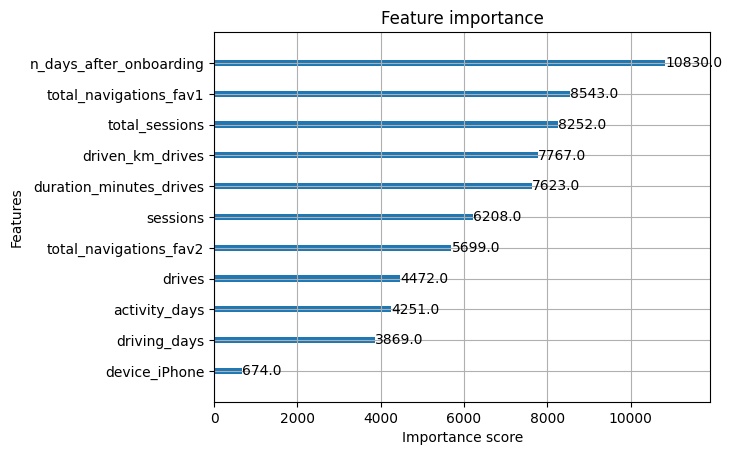

In [26]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_best)
plt.savefig("waze_visuals/image4", dpi=300)

plt.show()


In [27]:
y_pred_xgb_final = xgb_best.predict(X_test)
y_pred_rf_final = rf_best.predict(X_test)

from sklearn.metrics import classification_report

print("XGBoost Final Evaluation:\n", classification_report(y_test, y_pred_xgb_final))
print("Random Forest Final Evaluation:\n", classification_report(y_test, y_pred_rf_final))


XGBoost Final Evaluation:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      2353
           1       0.32      0.39      0.35       507

    accuracy                           0.75      2860
   macro avg       0.59      0.61      0.60      2860
weighted avg       0.77      0.75      0.76      2860

Random Forest Final Evaluation:
               precision    recall  f1-score   support

           0       0.88      0.76      0.82      2353
           1       0.32      0.52      0.40       507

    accuracy                           0.72      2860
   macro avg       0.60      0.64      0.61      2860
weighted avg       0.78      0.72      0.74      2860



In [30]:
pip install shap


  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/544.3 kB ? eta -:--:--
   --------------------------------------- 544.3/544.3 kB 17.6 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 32.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   --------- ------------------------------ 7.1/30.3 MB 36.3 MB/s eta 0:00:01
   ----------- ---------------------------- 8.4/30.3 MB 20.8 MB/s eta 0:00:02
   ------------ --------------------------- 9.7/30.3 MB 15.5 MB/s eta 0:00:02
   --------------- ------------------------ 12.1/30.3 MB 14.2 MB/s eta 0:00:02
   -------------------- ------------------- 15.2/30.3 MB 14.3 MB/s eta 0:00:02
   ----------------------- ---------------- 18.1/30.3 MB 14.3 MB/s eta 0:00:01
   -------------------------- ------------- 20.4

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


C:\Users\gowth\anaconda3\envs\clustering_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


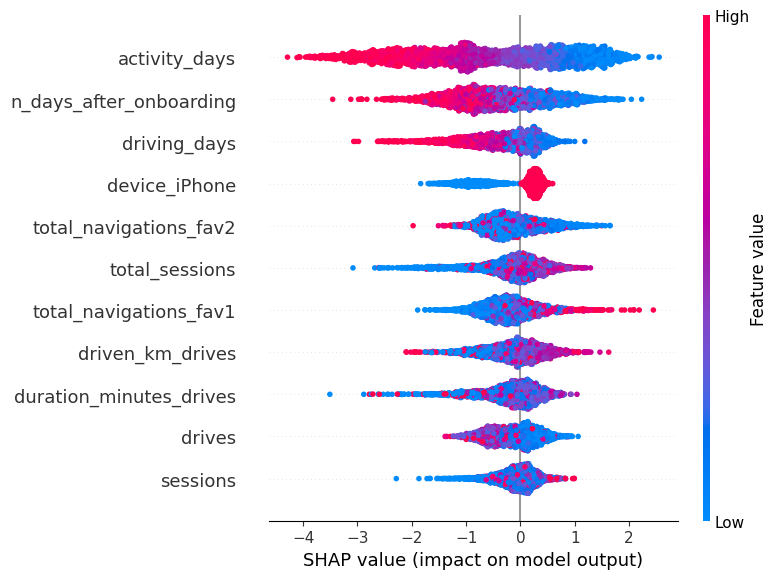

In [31]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_test)
plt.savefig("waze_visuals/image5", dpi=300)

shap.summary_plot(shap_values, X_test)


In [32]:
scale_weight = len(y_train_sm[y_train_sm == 0]) / len(y_train_sm[y_train_sm == 1])
xgb_best = XGBClassifier(**grid_xgb.best_params_, scale_pos_weight=scale_weight, random_state=42)
xgb_best.fit(X_train_sm, y_train_sm)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [33]:
rf_best = RandomForestClassifier(**grid_rf.best_params_, class_weight={0: 1, 1: 2}, random_state=42)
rf_best.fit(X_train_sm, y_train_sm)


RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=15,
                       n_estimators=300, random_state=42)

In [34]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_best),
    ('rf', rf_best)
], voting='soft') 

ensemble_model.fit(X_train_sm, y_train_sm)


y_pred_ensemble = ensemble_model.predict(X_test)
print("Ensemble Model Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print(classification_report(y_test, y_pred_ensemble))


Ensemble Model Accuracy: 0.7311188811188811
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      2353
           1       0.32      0.46      0.38       507

    accuracy                           0.73      2860
   macro avg       0.59      0.62      0.60      2860
weighted avg       0.77      0.73      0.75      2860

